* MNIST inverse network
* Newsgroups inverse network
* Squared error loss and classification loss
  * Also with L1 regularisation

In [1]:
import sys
import cPickle as pickle
import gzip
import random
from matplotlib import pyplot as plt
%matplotlib inline
sys.path.append("../modules/")
import helper as hp
# ----
import theano
from theano import tensor as T
import lasagne
import numpy as np
# ---
from skimage import io
# ---
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.init import *
from lasagne.updates import *
from lasagne.regularization import *
# ---
from scipy.io import loadmat
# ---
random.seed(0)
np.random.seed(0)

//anaconda/lib/python2.7/site-packages/Theano-0.8.0.dev0-py2.7.egg/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [574]:
%load_ext rmagic

//anaconda/lib/python2.7/site-packages/IPython/extensions/rmagic.py:11: UserWarning: The rmagic extension in IPython has moved to `rpy2.ipython`, please see `rpy2` documentation.
  warnings.warn("The rmagic extension in IPython has moved to "


In [2]:
def print_net(out):
    for layer in get_all_layers(out):
        print layer.output_shape
    print count_params(out)

* Load in the newsgroup dataset
* Add 100 random $U(0,1)$ (discrete) attributes to the end.

In [3]:
data = loadmat("../data/20news_w100.mat")
X_total = data["documents"].toarray().T
X_total = np.asarray(X_total, dtype="float32")
X_noise = np.asarray(np.random.randint(0, 2, (X_total.shape[0], X_total.shape[1])), dtype="float32")
X_total = np.hstack( (X_total, X_noise) )
y_total = data["newsgroups"]-1
y_total = np.asarray(y_total[0],dtype="int32")

In [4]:
def simple_mlp(X_data, y_data, lamb=0.0):
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_out = DenseLayer(a_in, num_units=np.max(y_data)+1, nonlinearity=softmax)   
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [161]:
mlp1 = simple_mlp(X_total, y_total, lamb=1e-4)

In [162]:
print_net(mlp1["net"])

(None, 200)
(None, 4)
804


In [41]:
def train_net(X_train, y_train, train_fn, num_epochs, batch_size, shuffle=True):
    idxs = [x for x in range(0, X_train.shape[0])]
    Xt, yt = X_train, y_train
    for epoch in range(0, num_epochs):
        if shuffle:
            random.shuffle(idxs)
            Xt = X_train[idxs]
            yt = y_train[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        print np.mean(losses)

In [45]:
def get_accuracy(X_train, y_train, predict_fn):
    return float(np.sum(np.argmax(predict_fn(X_train),axis=1) == y_train)) / len(y_train)

In [46]:
def get_mean_abs_grad(X_train, y_train, x_grad_fn):
    return np.mean(np.abs(x_grad_fn(X_train, y_train)),axis=0)

* Train a simple perceptron MLP on the newsgroup dataset with $L_{1}$
* Look at the accuracy and a plot of the mean absolute gradients over the training set (we expect the noise attributes to have low gradients)

In [164]:
train_net(X_total, y_total, mlp1["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.23782492573
0.960639491297
0.848167788826
0.784305225545
0.743613367122
0.713672729464
0.691508968917
0.674317077775
0.660457236334
0.647527825989
0.63826223627
0.629079979089
0.621915280712
0.615667768524
0.60946658993
0.604178421548
0.599059228146
0.595081339638
0.591303508491
0.587313707409
0.584546975842
0.581150863592
0.578920502777
0.576257051497
0.573726568034
0.570987052064
0.569266816217
0.567626849824
0.565838529677
0.563938650743
0.562113950668
0.56032212932
0.559437404324
0.55771197196
0.557043260298
0.555486703026
0.554498902576
0.552672347261
0.552092306087
0.55127030752
0.550372989862
0.549320239056
0.548901000415
0.547335477268
0.546944026156
0.545982552765
0.545147662821
0.544118613568
0.543581190859
0.543280369104
0.542228214874
0.541875568586
0.541428510473
0.540986840894
0.54008416404
0.539583482373
0.539327911776
0.539311553776
0.538282317624
0.537281528075
0.537239494005
0.536886463901
0.536271668828
0.536607975535
0.535751097298
0.535342858907
0.534710173516
0.

In [44]:
get_accuracy(X_total, y_total, mlp1["predict_fn"])

NameError: name 'get_accuracy' is not defined

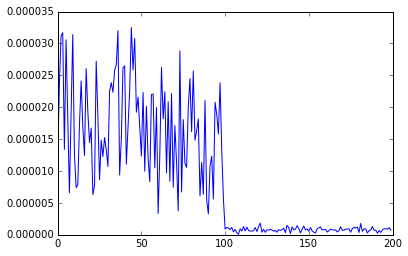

In [166]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp1["x_grad_fn"]) )

* Do the same thing but train an MLP (one hidden layer, with 100 hidden units)
* Evaluate accuracy
* Evaluate gradient plots for the input layer and the hidden layer

In [4]:
def mlp(X_data, y_data, num_hidden_units=None, lamb=0.0):
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # hacky
    z_hidden = InputLayer(a_hidden.output_shape, W=a_hidden.W)
    z_out = DenseLayer(z_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax, W=a_out.W)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    z_loss = categorical_crossentropy( get_output(z_out, X), y ).mean() + \
        lamb*regularize_layer_params(z_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    # the loss fn is defined in terms of X -> hidden -> out
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    # hacky
    hidden_grad_fn = theano.function([X, y], T.grad(z_loss, X))
    hidden_predict_fn = theano.function([X], get_output(a_hidden, X))
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "hidden_grad_fn":hidden_grad_fn,
            "hidden_predict_fn":hidden_predict_fn,
            "loss_fn": loss_fn}

In [91]:
def mlp(X_data, y_data, num_hidden_units=None, lamb=0.0):
    # prototype
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    #a_tmp = InputLayer( (None, 20) )
    #a_tmp2 = DenseLayer(a_tmp, num_units=num_hidden_units)
    #a_tmp3 = DenseLayer(a_tmp2, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    outputs = get_output([a_hidden, a_out], X)
    #print outputs
    loss = categorical_crossentropy( outputs[1], y ).mean() + \
        lamb*regularize_layer_params(a_out, l1)
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    #Compute dLoss / dX
    x_grad_fn = theano.function([X, y], theano.gradient.subgraph_grad(cost=loss, wrt=[X], end=[X])[0][0])
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    #Compute dLoss / dHidden
    hidden_grad_fn = theano.function([X, y],
            theano.subgraph_grad(cost=loss, wrt=[ outputs[0] ], end=[X])[0][0])
    hidden_predict_fn = theano.function([X], outputs[0])
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "hidden_grad_fn":hidden_grad_fn,
            "hidden_predict_fn":hidden_predict_fn,
            "loss_fn": loss_fn}

In [63]:
mlp2 = mlp(X_total, y_total, lamb=1e-4)

[Elemwise{mul,no_inplace}.0, Softmax.0]


In [64]:
train_net(X_total, y_total, mlp2["train_fn"], num_epochs=200, batch_size=128, shuffle=True)

1.19555065464
0.809396083683
0.657495903813
0.600676297496
0.57076333571
0.553588780822
0.540438661739
0.531441274122
0.526705587633
0.520925570466
0.515019106053
0.511680831425
0.506874260432
0.501677384157
0.499772505267
0.49596105838
0.490664108058
0.486086646678
0.484629150446
0.478740991708
0.476378800704
0.470840922174
0.467212729554
0.464487594351
0.459643347947
0.456515552104
0.449547810637
0.445540130483
0.44155478765
0.438572180992
0.434083477001
0.429671681032
0.425157619484
0.418439357126
0.414678930263
0.410895382979
0.406299903827
0.401127986962
0.395739789491
0.392536236744
0.387241064885
0.381632124225
0.376484799211
0.373053848005
0.367720279575
0.362138286268
0.357753843748
0.353165004638
0.349162825145
0.343509415456
0.339802465291
0.334388900507
0.330935754959
0.325991679999
0.322249149002
0.318239052174
0.312216630151
0.309147074148
0.304561539377
0.299475027512
0.295600242117
0.291833002464
0.286084997559
0.28428117227
0.279152172429
0.274756071285
0.27143442883
0

In [65]:
get_accuracy(X_total, y_total, mlp2["predict_fn"])

1.0

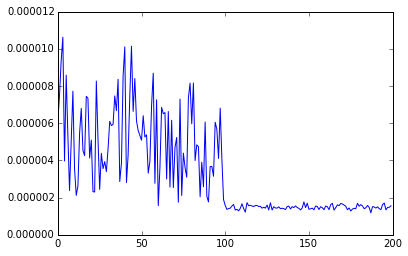

In [79]:
plt.plot( get_mean_abs_grad(X_total, y_total, mlp2["x_grad_fn"]) )

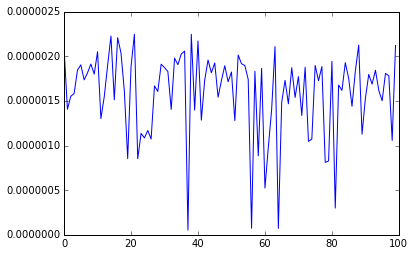

In [68]:
mlp2_hidden_grads = mlp2["hidden_grad_fn"](X_total, y_total)
plt.plot( np.mean(np.abs(mlp2_hidden_grads), axis=0) )

* Generate an MLP with no $L_{1}$ regularisation (we want to overfit the training set, and see how the validation set reacts).
* Let's train our network and after each epoch, save a plot of the (validation set) input and hidden gradients to disk.

In [69]:
%%bash
mkdir -p feature_ranking_out/input_grads
mkdir -p feature_ranking_out/hidden_grads

In [82]:
mlp3 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)

[Elemwise{mul,no_inplace}.0, Softmax.0]


In [71]:
print_net(mlp3["net"])

(None, 200)
(None, 100)
(None, 4)
20504


Cut the data into training and validation.

In [72]:
X_total.shape, y_total.shape

((16242, 200), (16242,))

In [73]:
idxs = [x for x in range(0, X_total.shape[0])]
random.shuffle(idxs)
train_idxs = idxs[0 : int(0.75*len(idxs))]
valid_idxs = idxs[int(0.75*len(idxs)) :: ]
Xt, yt, Xv, yv = X_total[train_idxs], y_total[train_idxs], X_total[valid_idxs], y_total[valid_idxs]

In [74]:
Xt.shape, yt.shape, Xv.shape, yv.shape

((12181, 200), (12181,), (4061, 200), (4061,))

In [80]:
def graph_grad_train(Xt, yt, Xv, yv, mlp, num_epochs=20, batch_size=128):
    
    hidden_grads_arr = []
    input_grads_arr = []
    
    idxs = [x for x in range(0, Xt.shape[0])]
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = mlp["train_fn"](
                Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        input_grads = mlp["x_grad_fn"](Xv, yv)
        input_grads = np.mean(np.abs(input_grads), axis=0)
        hidden_grads = mlp["hidden_grad_fn"](Xv, yv)
        np.savetxt("feature_ranking_out/hidden_grads/%s.csv" % str(epoch+1).zfill(2),
                   hidden_grads, delimiter=",", fmt="%5.5e")
        hidden_grads = np.mean(np.abs(hidden_grads), axis=0)   
        
        # save grads
        input_grads_arr.append(input_grads)
        hidden_grads_arr.append(hidden_grads)
        this_valid_loss = mlp["loss_fn"](Xv, yv)
        print "train loss, valid loss = %f, %f" % (np.mean(losses), this_valid_loss)
       
    print "plotting..."
    biggest_input_max = -1
    biggest_hidden_max = -1
    for i in range(0, len(hidden_grads_arr)):
        if np.max(hidden_grads_arr[i]) > biggest_hidden_max:
            biggest_hidden_max = np.max(hidden_grads_arr[i])
        if np.max(input_grads_arr[i]) > biggest_input_max:
            biggest_input_max = np.max(input_grads_arr[i])
            
    for epoch in range(0, num_epochs):
        plt.ylim(0, biggest_hidden_max)
        plt.plot(hidden_grads_arr[epoch])
        plt.savefig("feature_ranking_out/hidden_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()
        plt.ylim(0, biggest_input_max)
        plt.plot(input_grads_arr[epoch])
        plt.savefig("feature_ranking_out/input_grads/%s.png" % str(epoch+1).zfill(2))
        plt.close()

In [83]:
graph_grad_train(Xt, yt, Xv, yv, mlp3, num_epochs=100)

train loss, valid loss = 1.265682, 1.095089
train loss, valid loss = 0.937777, 0.811730
train loss, valid loss = 0.731964, 0.676413
train loss, valid loss = 0.643457, 0.634058
train loss, valid loss = 0.596938, 0.612812
train loss, valid loss = 0.568607, 0.572648
train loss, valid loss = 0.554042, 0.616587
train loss, valid loss = 0.541818, 0.560268
train loss, valid loss = 0.530589, 0.570906
train loss, valid loss = 0.520501, 0.553255
train loss, valid loss = 0.515452, 0.539677
train loss, valid loss = 0.509300, 0.548752
train loss, valid loss = 0.504063, 0.552121
train loss, valid loss = 0.496826, 0.545204
train loss, valid loss = 0.494875, 0.537638
train loss, valid loss = 0.487245, 0.530217
train loss, valid loss = 0.481830, 0.572776
train loss, valid loss = 0.476298, 0.546551
train loss, valid loss = 0.471664, 0.533995
train loss, valid loss = 0.471008, 0.542909
train loss, valid loss = 0.466045, 0.531833
train loss, valid loss = 0.461121, 0.551483
train loss, valid loss = 0.45465

In [78]:
get_accuracy(Xt, yt, mlp3["predict_fn"]), get_accuracy(Xv, yv, mlp3["predict_fn"])

(0.9867005992939825, 0.7660674710662398)

* Over time, the validation set gradients for input/hidden layers gets larger. Is this because the network is overfitting the training set, and hence the $\frac{dL}{dx}$ has hit a local minimum, whereas this is not the case with the validation set?
* Let's look at the hidden activation gradients for the validation set, and sort them

In [84]:
mlp3_hidden_grads = mlp3["hidden_grad_fn"](Xv, yv)
mlp3_hidden_grads_mean = np.mean(np.abs(mlp3_hidden_grads), axis=0)
mlp3_hidden_grads_std = np.std(np.abs(mlp3_hidden_grads), axis=0)

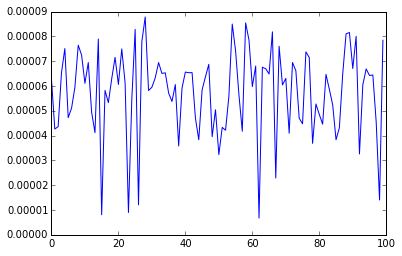

In [85]:
plt.plot(mlp3_hidden_grads_mean)

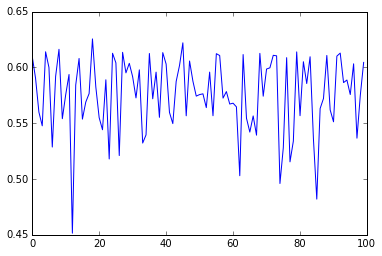

In [86]:
plt.plot(mlp3_hidden_grads_mean / mlp3_hidden_grads_std)

In [50]:
np.argsort(mlp3_hidden_grads_mean)

array([56, 11, 65, 84, 92,  0, 71, 77, 64,  7, 78, 60, 33, 63,  2, 28,  5,
       36, 73, 10,  8, 87, 35,  4, 67, 69, 79, 22, 90, 14, 55, 19, 59, 23,
        6, 62, 12, 99, 43, 42, 74, 83, 41,  3, 39, 91, 72, 13, 31, 47, 58,
       40, 76, 32, 34, 49, 81, 50, 75, 25, 95, 53, 38, 48, 17, 54, 88, 94,
       37, 51, 80, 96, 52, 82, 68, 24, 16, 66, 27, 15, 57, 97, 21,  9, 85,
       18,  1, 98, 26, 46, 89, 45, 30, 93, 86, 20, 44, 29, 70, 61])

In [94]:
np.argsort(mlp3_hidden_grads_mean / mlp3_hidden_grads_std)

array([12, 85, 74, 62, 77, 23, 26, 75,  6, 33, 78, 84, 97, 67, 34, 65, 21,
        3, 42, 90, 15,  9, 64, 20, 38, 66, 46, 54, 80, 41,  2, 89, 86, 52,
       61, 59, 60, 16, 36, 87, 57, 31, 69, 49, 98, 10, 50, 95, 51, 17, 58,
       19, 13, 82, 93, 43, 48, 94, 22,  1, 30,  7, 11, 28, 37, 53, 32, 70,
       71,  5, 44, 40, 96, 29, 25, 99, 81, 47, 14, 76, 83,  0, 91, 73, 56,
       88, 72, 63, 55, 35, 68, 24, 92, 39, 27, 79,  4,  8, 45, 18])

In [105]:
mlp3["net"].input_layer.W.get_value()[:,12].shape

(200,)

* Can we visualise a histogram of hidden activation gradients (over the validation set) for each hidden unit?

(array([   63.,   113.,   171.,   210.,  1510.,  1562.,   178.,   135.,
           96.,    23.]),
 array([ -6.32923745e-05,  -5.06339856e-05,  -3.79755967e-05,
         -2.53172079e-05,  -1.26588190e-05,  -4.30141856e-10,
          1.26579587e-05,   2.53163476e-05,   3.79747365e-05,
          5.06331253e-05,   6.32915142e-05]),
 <a list of 10 Patch objects>)

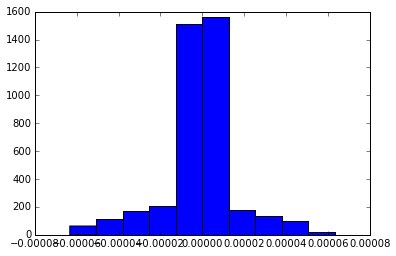

In [453]:
plt.hist( mlp3["hidden_grad_fn"]( mlp3["hidden_predict_fn"](Xv).astype("float32"), yv)[:,39] )

* Train on all minibatches
* Evaluate performance of hidden layer on validation set
* Find the M worst hidden units (i.e. the ones with high mean gradients), and reinitialise their weights

In [119]:
def adaptive_train(Xt, yt, Xv, yv, mlp, num_to_fix, check_every, 
                   batch_size, num_epochs=20, add_noise=False, print_out=True):
    sampler = GlorotUniform()
    idxs = [x for x in range(0, Xt.shape[0])]
    train_fn = mlp["train_fn"]
    hidden_predict_fn = mlp["hidden_predict_fn"]
    hidden_grad_fn = mlp["hidden_grad_fn"]
    net = mlp["net"]
    h_grads_arr = []
    for epoch in range(0, num_epochs):
        random.shuffle(idxs)
        Xt = Xt[idxs]
        yt = yt[idxs]
        b = 0
        losses = []
        while True:
            if b*batch_size >= Xt.shape[0]:
                break
            this_loss = train_fn(Xt[b*batch_size : (b+1)*batch_size], yt[b*batch_size : (b+1)*batch_size])
            losses.append(this_loss)
            b += 1
        if num_to_fix > 0:
            h_grads = hidden_grad_fn(Xv, yv)
            h_grads_mean = np.mean(np.abs(h_grads), axis=0)
            h_grads_std = np.std(np.abs(h_grads), axis=0)
            h_grads = h_grads_mean / h_grads_std
            h_idxs = np.argsort(h_grads)[::-1]
        #print "units to fix: %s" % str(h_idxs[0:num_to_fix])
        if num_to_fix > 0 and (epoch+1) % check_every == 0:
            W = net.input_layer.W.get_value()
            for idx in h_idxs[0:num_to_fix]:
                if add_noise:
                    W[:,idx] += np.random.normal(0, 0.1, size=( W[:,idx].shape[0], 1) ).flatten()
                else:
                    W[:,idx] = sampler.sample( ( W[:,idx].shape[0], 1) ).flatten()
            net.input_layer.W.set_value(W)
        if print_out:
            print np.mean(losses)
    return h_grads_arr

In [121]:
for check_every in [1, 20]:
    rows_to_write = []
    for num_to_fix in [0, 5, 10, 20, 40, 80]:
        valid_accs = []
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp4 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(Xt, yt, Xv, yv, mlp4, 
                batch_size=128, num_epochs=100, num_to_fix=num_to_fix, check_every=check_every, print_out=False)
            valid_acc = get_accuracy(Xv, yv, mlp4["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row
    with open("feature_ranking_out_adaptive/stats%i.csv" % check_every, "wb") as f:
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

[0, 0, 0.7638512681605516]
[0, 1, 0.7677911844373307]
[0, 2, 0.7527702536321104]
[0, 3, 0.7621275547894607]
[0, 4, 0.7660674710662398]
[0, 5, 0.7557251908396947]
[0, 6, 0.7574489042107855]
[0, 7, 0.7608963309529673]
[0, 8, 0.7549864565377986]
[0, 9, 0.7613888204875646]
[5, 0, 0.7707461216449151]
[5, 1, 0.7660674710662398]
[5, 2, 0.7527702536321104]
[5, 3, 0.7695148978084215]
[5, 4, 0.7601575966510712]
[5, 5, 0.7695148978084215]
[5, 6, 0.7557251908396947]
[5, 7, 0.7503078059591234]
[5, 8, 0.7660674710662398]
[5, 9, 0.7426742181728638]
[10, 0, 0.767544939670032]
[10, 1, 0.7781334646638759]
[10, 2, 0.7670524501354347]
[10, 3, 0.7564639251415908]
[10, 4, 0.7633587786259542]
[10, 5, 0.7399655257325782]
[10, 6, 0.7515390297956168]
[10, 7, 0.7702536321103176]
[10, 8, 0.7608963309529673]
[10, 9, 0.7407042600344743]
[20, 0, 0.7150948042354099]
[20, 1, 0.7766559960600837]
[20, 2, 0.7729623245506033]
[20, 3, 0.7719773454814085]
[20, 4, 0.7712386111795124]
[20, 5, 0.651317409505048]
[20, 6, 0.6788

* Weight change every epoch = 80 does better than everything else (seems too brute force?)
* Weight change every 20 epochs = 80 does worse

In [615]:
for check_every in [20]:
    rows_to_write = []
    for num_to_fix in [0, 5, 10]:
        valid_accs = []
        # row in the format "num_to_fix,seed,valid_acc
        for x in range(0, 10):
            row = [num_to_fix, x]
            np.random.seed(x)
            random.seed(x)
            mlp4 = mlp(X_total, y_total, num_hidden_units=None, lamb=0.0)
            h_grads_arr = adaptive_train(
                Xt, yt, Xv, yv, mlp4, num_epochs=100, num_to_fix=num_to_fix, check_every=check_every, add_noise=True, print_out=False)
            valid_acc = get_accuracy(Xv, yv, mlp4["predict_fn"])
            row.append(valid_acc)
            valid_accs.append(valid_acc)
            rows_to_write.append(row)
            print row

    with open("feature_ranking_out_adaptive/noise_stats%i.csv" % check_every, "wb") as f:
        f.write("num_to_fix,seed,valid_accuracy\n")
        for row in rows_to_write:
            f.write(",".join( [str(r) for r in row] ) + "\n")

[0, 0, 0.7709923664122137]
[0, 1, 0.7589263728145776]
[0, 2, 0.756217680374292]
[0, 3, 0.7606500861856685]
[0, 4, 0.7576951489780842]
[0, 5, 0.7606500861856685]
[0, 6, 0.758680128047279]
[0, 7, 0.7690224082738242]
[0, 8, 0.7655749815316425]
[0, 9, 0.7576951489780842]
[5, 0, 0.7522777640975129]
[5, 1, 0.7453829106131494]
[5, 2, 0.7453829106131494]
[5, 3, 0.7535089879340064]
[5, 4, 0.7544939670032011]
[5, 5, 0.7443979315439547]
[5, 6, 0.7552327013050972]
[5, 7, 0.7653287367643438]
[5, 8, 0.7463678896823442]
[5, 9, 0.7463678896823442]
[10, 0, 0.7557251908396947]
[10, 1, 0.7244521053927604]
[10, 2, 0.741689239103669]
[10, 3, 0.7468603792169416]
[10, 4, 0.7054912583107609]
[10, 5, 0.7512927850283182]
[10, 6, 0.7532627431667077]
[10, 7, 0.7493228268899286]
[10, 8, 0.7411967495690717]
[10, 9, 0.7495690716572273]


In [555]:
for i in range(0, len(h_grads_arr)):
    plt.ylim(0, 0.000050)
    plt.plot(h_grads_arr[i])
    plt.savefig("feature_ranking_out_adaptive/%s.png" % str(i+1).zfill(2))
    plt.close()

----

* Plot the gradients on MNIST digits. This makes a nice visualisation which could make it into the paper.

In [380]:
sys.path.append("../modules/")
import helper as hp

In [381]:
mnist_train_set, _, _ = hp.load_mnist()

In [387]:
mnist_x, mnist_y = mnist_train_set
mnist_x = mnist_x.astype("float32")
mnist_y = mnist_y.astype("int32")

In [383]:
def simple_conv(X_data, y_data):
    a_in = InputLayer( (None, 1, 28, 28 ) )
    a_conv1 = Conv2DLayer(a_in, num_filters=16, filter_size=(5,5), nonlinearity=rectify)
    a_mp1 = MaxPool2DLayer(a_conv1, pool_size=(2,2))
    a_conv2 = Conv2DLayer(a_mp1, num_filters=32, filter_size=(5,5), nonlinearity=rectify)
    a_mp2 = MaxPool2DLayer(a_conv2, pool_size=(2,2))
    a_out = DenseLayer(a_mp2, num_units=np.max(y_data)+1, nonlinearity=softmax)  
    X = T.tensor4('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean()
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn}

In [384]:
conv = simple_conv(mnist_x, mnist_y)

In [388]:
train_net(mnist_x, mnist_y, conv["train_fn"], num_epochs=5, batch_size=64)

0.26089267387
0.0771458087307
0.0571138216773


KeyboardInterrupt: 

In [393]:
mnist_x_9 = mnist_x[ (mnist_y == 9) ]
mnist_y_9 = np.asarray([9 for x in range(0, mnist_x_9.shape[0])], dtype="int32")

In [394]:
grads_for_9 = conv["x_grad_fn"](mnist_x_9, mnist_y_9)

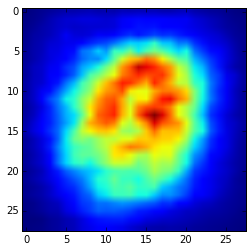

In [403]:
plt.imshow( np.mean(np.abs(grads_for_9),axis=0)[0] )

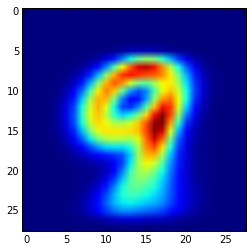

In [404]:
plt.imshow( np.mean(np.abs(mnist_x_9),axis=0)[0] )

----

* Not using autoencoders, because the noise attributes actually get larger gradients. Because they have no structure to them, the network allocates more capacity to them, and hence they end up being more important attributes.

----

In [8]:
?T.sqr

In [135]:
def mlp_fnorm(X_data, y_data, num_hidden_units=None, lamb=0.0):
    """
    We have an MLP x -> h -> y.
    Let's apply the data regulariser ||dy/dh||_{F}^2
    """
    if num_hidden_units == None:
        num_hidden_units = X_data.shape[1]/2
    a_in = InputLayer( (None, X_data.shape[1]) )
    a_hidden = DenseLayer(a_in, num_units=num_hidden_units)
    a_out = DenseLayer(a_hidden, num_units=np.max(y_data)+1, nonlinearity=softmax)
    # ---
    X = T.fmatrix('X')
    y = T.ivector('y')
    loss = categorical_crossentropy( get_output(a_out, X), y ).mean() + \
        lamb*1
    params = get_all_params(a_out)
    updates = nesterov_momentum(loss, params, 0.01, 0.9)
    train_fn = theano.function([X, y], loss, updates=updates)
    # the loss fn is defined in terms of X -> hidden -> out
    x_grad_fn = theano.function([X, y], T.grad(loss, X))
    predict_fn = theano.function([X], get_output(a_out, X) )
    loss_fn = theano.function([X, y], loss )
    
    tmp_fn = theano.function([X], 
        theano.gradient.jacobian( get_output(a_hidden, X).flatten(), X ))
    
    # ---
    return {"net": a_out,
            "train_fn":train_fn,
            "x_grad_fn":x_grad_fn,
            "predict_fn":predict_fn,
            "loss_fn": loss_fn,
            "tmp_fn": tmp_fn}

In [136]:
tmp_fn = mlp_fnorm(X_total, y_total)["tmp_fn"]

In [143]:
tmp_fn(X_total[0:4]).shape

(400, 4, 200)

In [138]:
?theano.gradient.jacobian

In [142]:
X_total[0:4].shape

(4, 200)